In [1]:
import tensorly as tl
import tensorly.decomposition as td
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
import dill
import os
from glob import glob
import pandas as pd
import datatable as dt

from functools import partial

In [2]:
DATADIR = './data/bangalore/2019q4'

hourdf =  pd.read_csv(f'{DATADIR}/bangalore-wards-2019-4-OnlyWeekdays-HourlyAggregate.csv')
monthdf = pd.read_csv(f'{DATADIR}/bangalore-wards-2019-4-OnlyWeekdays-MonthlyAggregate.csv')
daydf = pd.read_csv(f'{DATADIR}/bangalore-wards-2019-4-WeeklyAggregate.csv')

In [3]:
bdata = [hourdf, monthdf, daydf]
MAX_REGION_ID = max([ max(x.sourceid.max(),x.dstid.max()) for x in bdata])
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 5
MONTHS_IN_QUARTER = 3

In [4]:
TENSOR_H = np.zeros((MAX_REGION_ID,MAX_REGION_ID,HOURS_IN_DAY))
TENSOR_D = np.zeros((MAX_REGION_ID,MAX_REGION_ID,DAYS_IN_WEEK))
TENSOR_M = np.zeros((MAX_REGION_ID,MAX_REGION_ID,MONTHS_IN_QUARTER))

In [5]:
hourdf.head(1)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,30,165,7,5879.91,1174.47,5775.02,1.2


In [6]:
daydf.head(1)

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,145,121,7,1334.07,561.3,1268.67,1.35


In [7]:
monthdf.head(1)

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,24,129,12,2516.94,919.39,2375.28,1.4


In [8]:
def filltensor(_df, tensor, axis3='hod', axis3offby=0, metric='mean_travel_time', filter_=None):
    if filter_: _df = _df[filter_(_df)]
    tensor[_df.dstid-1, _df.sourceid-1, _df[axis3]-axis3offby ] = _df[metric]

In [9]:
_fill=partial(filltensor, tensor=TENSOR_H, axis3='hod', metric='mean_travel_time')
_fill(hourdf)
#TENSOR_H *= 7/5

In [10]:
_fill=partial(filltensor, tensor=TENSOR_D, axis3='dow',axis3offby=1, metric='mean_travel_time',  filter_ = lambda dframe: dframe.dow <= 5)
daydf.pipe(_fill)

In [11]:
_fill=partial(filltensor, tensor=TENSOR_M, axis3='month',axis3offby=10, metric='mean_travel_time')
monthdf.pipe(_fill)
#TENSOR_M*=7/5

In [210]:
__rank=2

#method='parafac'       
        
"""
def decompose(method='parafac'):
    if method in ['parafac']:
        decompose = partial(td.parafac, rank=__rank, return_errors=True, n_iter_max=10000, normalize_factors=True)
        weights,factors = params

    elif method in ['non_negative_parafac']:
        decompose = partial(td.non_negative_parafac, rank=__rank, return_errors=True, n_iter_max=10000, normalize_factors=False)
        weights, factors = params

    elif method in ['parafac2']:
        decompose = partial(td.parafac2, rank=__rank, return_errors=True)
        weights, factors, projection_matrices = params
"""
decompose = partial(td.parafac, rank=__rank, return_errors=True, n_iter_max=10000, normalize_factors=True)
decompose = partial(td.non_negative_parafac, rank=__rank, return_errors=True, n_iter_max=10000, normalize_factors=False)
#decompose = partial(td.parafac2, rank=__rank, return_errors=True)

params, errors = decompose(TENSOR_H)
print(len(errors),errors[-1])
weightsH,factorsH,*others  = params 

params, errors = decompose(TENSOR_D)
print(len(errors),errors[-1])
weightsD,factorsD,*others  = params

params, errors = decompose(TENSOR_M)
print(len(errors),errors[-1])
#print(params[1])
weightsM,factorsM,*others  = params 

63 0.385255919420759
182 0.30179833406328266
193 0.2980509733934793


In [211]:
for i in [0,1]:
    factorsM[i] = factorsM[i] @ np.sqrt(np.diag(1/np.diag(factorsM[i].T @ factorsM[i])))
    factorsH[i] = factorsH[i] @ np.sqrt(np.diag(1/np.diag(factorsH[i].T @ factorsH[i])))
    factorsD[i] = factorsD[i] @ np.sqrt(np.diag(1/np.diag(factorsD[i].T @ factorsD[i])))
    

In [212]:
factorsM[0].T @ factorsM[0]

array([[1.        , 0.53911071],
       [0.53911071, 1.        ]])

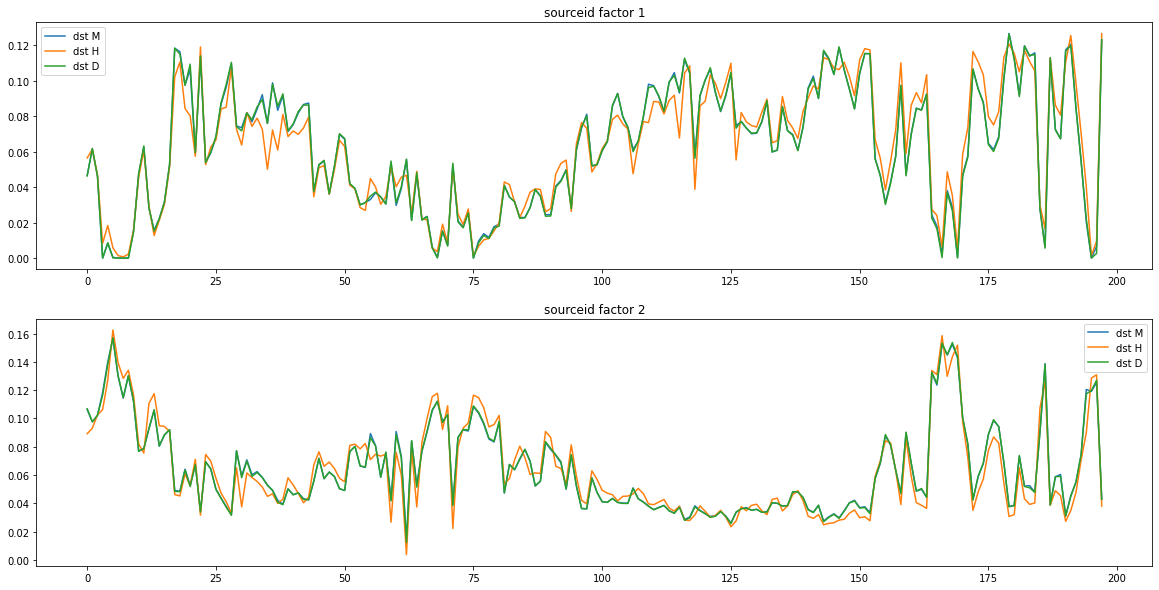

In [213]:
__nplots = factorsM[0].shape[1]


if __nplots == 1:
    sns.lineplot(data=factorsM[1][:,0], label='dst M')
    sns.lineplot(data=factorsH[1][:,0], label='dst H')
    sns.lineplot(data=factorsD[1][:,0], label='dst D')
else:
    fig, axes = plt.subplots(__nplots, 1, figsize=(20, 5*__nplots), sharey=False)
    for __i,__a in enumerate(axes):
        sns.lineplot(ax=__a, data=factorsM[1][:,__i], label='dst M')
        sns.lineplot(ax=__a, data=factorsH[1][:,__i], label='dst H')
        sns.lineplot(ax=__a, data=factorsD[1][:,__i], label='dst D')
        __a.set_title(f'sourceid factor {__i+1}')

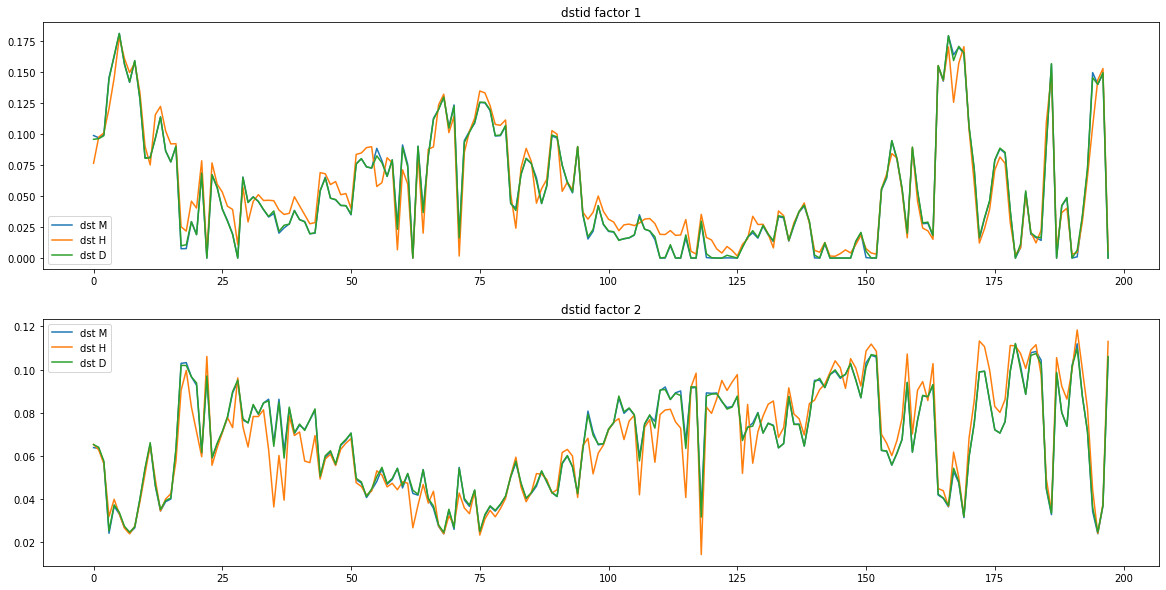

In [214]:
__nplots = factorsM[0].shape[1]

if __nplots==1:
    sns.lineplot(data=factorsM[0][:,0], label='dst M')
    sns.lineplot(data=factorsH[0][:,0], label='dst H')
    sns.lineplot(data=factorsD[0][:,0], label='dst D')
else:
    fig, axes = plt.subplots(__nplots, 1, figsize=(20,5*__nplots), sharey=False)
    for __i,__a in enumerate(axes):
        sns.lineplot(ax=__a, data=factorsM[0][:,__i], label='dst M')
        sns.lineplot(ax=__a, data=factorsH[0][:,__i], label='dst H')
        sns.lineplot(ax=__a, data=factorsD[0][:,__i], label='dst D')
        __a.set_title(f'dstid factor {__i+1}')

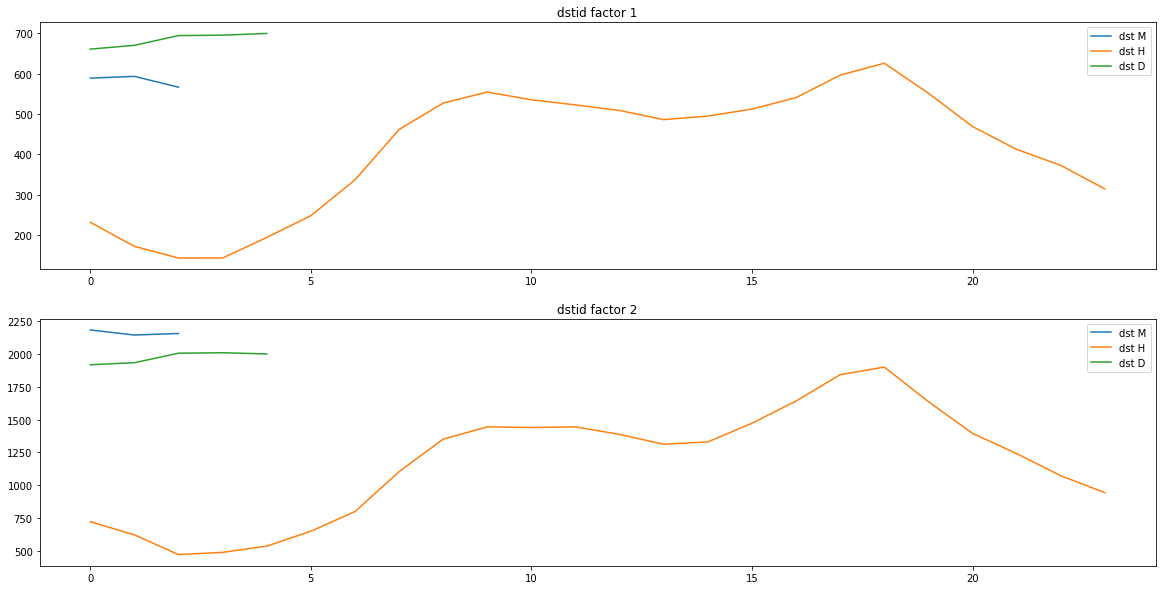

In [215]:
__nplots = factorsM[0].shape[1]

if __nplots==1:
    sns.lineplot(data=factorsM[2][:,0], label='dst M')
    sns.lineplot(data=factorsH[2][:,0], label='dst H')
    sns.lineplot(data=factorsD[2][:,0], label='dst D')
else:
    fig, axes = plt.subplots(__nplots, 1, figsize=(20,5*__nplots), sharey=False)
    for __i,__a in enumerate(axes):
        sns.lineplot(ax=__a, data=factorsM[2][:,__i], label='dst M')
        sns.lineplot(ax=__a, data=factorsH[2][:,__i], label='dst H')
        sns.lineplot(ax=__a, data=factorsD[2][:,__i], label='dst D')
        __a.set_title(f'dstid factor {__i+1}')